<a href="https://colab.research.google.com/github/SmithTheGreat/Romit-Ghosh-MIT-Maker-Portfolio-SRC/blob/main/Market_Making_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from collections import deque

In [15]:
class Order:
  def __init__(self, side, price, size, order_type):
    self.side = side
    self.price = price
    self.size = size
    self.order_type = order_type
  def __repr__(self):
    return f"Order: side = {self.side}, price = {self.price}, size = {self.size}, order type = {self.order_type}"


In [16]:
class OrderBook:
  def __init__(self):
    self.bids = {}
    self.asks = {}
  def best_bid(self):
    if not self.bids:
      return None
    return max(self.bids.keys())
  def best_ask(self):
    if not self.asks:
      return None
    return min(self.asks.keys())
  def add_limit(self, order):
    if order.side == "buy" :
      book = self.bids
    else:
      book = self.asks

    if order.price in book:
      book[order.price] += order.size
    else:
      book[order.price] = order.size

  def execute_order(self, order) :
    trades = []
    if order.side == "buy":
      book = self.asks
      best_price = min
    else:
      book = self.bids
      best_price = max

    while order.size > 0 and book:
      curr_price = best_price(book.keys())
      available = book[curr_price]
      traded = min(order.size, available)
      trades.append((curr_price, traded))
      book[curr_price] -= traded
      order.size -= traded

      if book[curr_price] == 0:
        del book[curr_price]

    return trades

In [17]:
class OrderFlow:
  def __init__(self, p_market = 0.4, tick = 0.01) :
    self.p_market = p_market
    self.tick = tick

  def generate_order(self, mid_price):
    side = random.choice(["buy", "sell"])
    size = int(np.random.exponential(15)) + 1

    if random.random() < self.p_market:
      return Order(side, None, size, "market")

    level = random.randint(1,5)
    offset = level * self.tick

    if side == "buy":
      price = mid_price - offset
    else:
      price = mid_price + offset

    return Order(side, price, size, "limit")

In [18]:
class Simulator:
  def __init__(self, steps = 1000, agent = None, candle_interval = 50):
    self.steps = steps
    self.book = OrderBook()
    self.flow = OrderFlow()
    self.mid_prices = []
    self.spreads = []
    self.agent = agent
    self.candles = CandleTracker(interval = candle_interval)

    #seeding initial liquidity
    mid = 100.0
    for i in range(1,20) :
      self.book.bids[mid - i * 0.01] = 10
      self.book.asks[mid + i * 0.01] = 10

  def run(self) :
    prev_mid = None
    for time in range(self.steps):
      bid = self.book.best_bid()
      ask = self.book.best_ask()

      if bid is None or ask is None:
        continue

      mid = (bid+ask)/2
      self.mid_prices.append(round(mid,2))
      self.candles.add_candle(round(mid,2))

      spread = ask - bid
      self.spreads.append(round(spread, 2))

      #Agent Strategy -> simple mean reversion
      if self.agent and prev_mid is not None:

        if mid < prev_mid:
          trades = self.execute_agent_order("buy", size = 2)
          for price, qty in trades:
            self.agent.buy(price, qty, time)

        elif mid > prev_mid:
          trades = self.execute_agent_order("sell", size = 2)
          for price, qty in trades:
            self.agent.sell(price, qty, time)

      #order flow
      order = self.flow.generate_order(mid)

      if order.order_type == "market":
        self.book.execute_order(order)
      else:
        self.book.add_limit(order)

      prev_mid = mid

  def execute_agent_order(self, side, size) :
    order = Order(side, None, size, "market")
    trades = self.book.execute_order(order)
    return trades

In [19]:
class TradingAgent:
  def __init__(self):
    self.shares = 0
    self.cash = 0.0
    self.trade_log = []

  def buy(self, price, size, time):
    self.shares += size
    self.cash -= price * size
    self.trade_log.append(("buy", round(price,2), size, time))

  def sell(self, price, size, time):
    self.shares -= size
    self.cash += price * size
    self.trade_log.append(("sell", round(price,2), size, time))

  def value(self,mid_price):
    return self.cash + self.shares * mid_price

In [20]:
class CandleTracker:
  def __init__(self, interval = 50):
    self.interval = interval
    self.candles = []
    self.buffer = []
  def add_candle(self, price):
    self.buffer.append(price)
    if len(self.buffer) >= self.interval:
      open = self.buffer[0]
      high = max(self.buffer)
      low = min(self.buffer)
      close = self.buffer[-1]
      self.candles.append({'open': open, 'high': high, "low": low, 'close': close})
      self.buffer = []


In [21]:
class Hawkes:
  def __init__ (self, mu, alpha, beta):
    self.mu = mu
    self.alpha = alpha
    self.beta = beta
    self.events = []
  def intensity(self, t) :
    lam = self.mu
    for j in  self.events:
      lam += self.alpha * math.exp(-self.beta * (t-j))
    return lam
  def sample_next_event(self, t):
    lam = self.intensity(t)
    dt = random.expovariate(lam)
    self.events.append(t + dt)
    return t + dt

In [22]:
def plot_candles(candles):
  fig, ax = plt.subplots()

  def animate(i):
    ax.cla()
    data = candles.candles[:i+1]
    if not data:
      return
    lows = []
    highs = []
    for idx, c in enumerate(data):
      color = 'green' if c['close'] >= c['open'] else 'red'
      ax.plot([idx, idx], [c['low'], c['high']], color = 'black')
      ax.add_patch(Rectangle((idx-0.2, c['open']), 0.4, c['close'] - c['open'], color = color))
      lows.append(c['low'])
      highs.append(c['high'])

    ax.set_ylim(min(lows) - 0.05, max(highs) + 0.05)
    ax.set_xlim(-1, len(data))
    ax.set_title('Candlestick Price Chart')
    ax.set_xlabel('Candle Index')
    ax.set_ylabel('Price')
  anim = FuncAnimation(fig,animate,frames = len(candles.candles), interval = 200)
  return anim

In [23]:
agent = TradingAgent()
sim = Simulator(steps = 5000, agent = agent, candle_interval = 20)
sim.run()

print(sim.mid_prices[:10])
print("Final mid price: $" + str(round(sim.mid_prices[-1],2)))
print("Trading agent account value(cash + stocks): $" +str(round(agent.value(round(sim.mid_prices[-1],2)),2)))
print(agent.trade_log[-10:])

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Final mid price: $99.93
Trading agent account value(cash + stocks): $-68.69
[('buy', 99.95, 2, 4981), ('buy', 99.95, 2, 4983), ('sell', 99.92, 2, 4984), ('sell', 99.92, 2, 4988), ('sell', 99.92, 1, 4995), ('sell', 99.91, 1, 4995), ('buy', 99.95, 2, 4996), ('buy', 99.95, 1, 4998), ('buy', 99.95, 1, 4998), ('sell', 99.91, 2, 4999)]


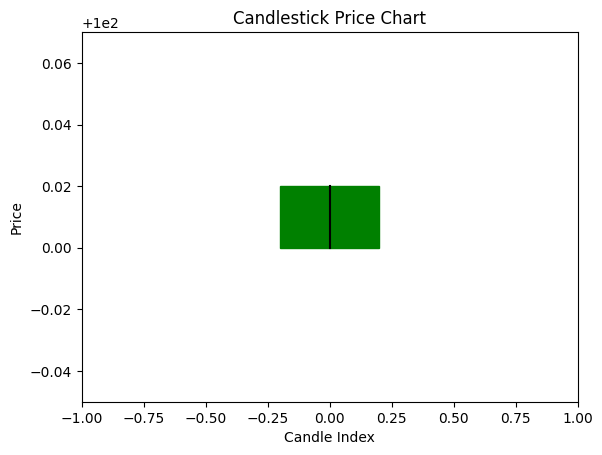

In [24]:
from IPython.display import HTML

anim = plot_candles(sim.candles)
HTML(anim.to_jshtml())

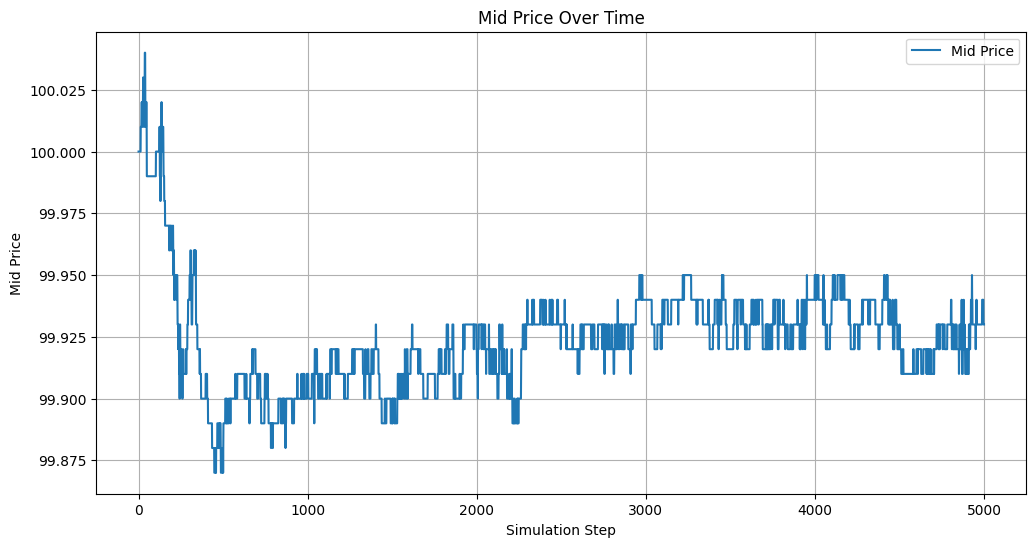

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(sim.mid_prices, label='Mid Price')
plt.xlabel('Simulation Step')
plt.ylabel('Mid Price')
plt.title('Mid Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

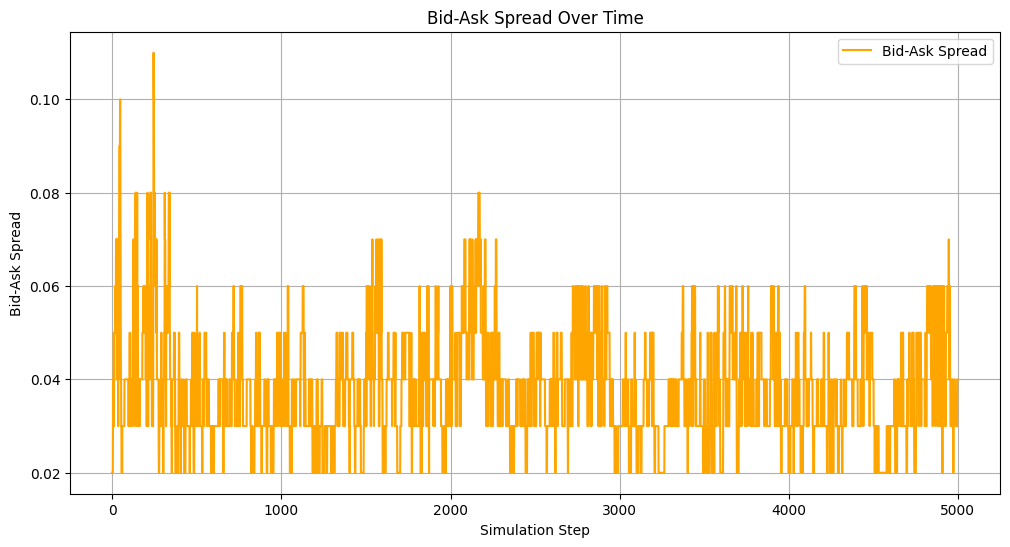

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(sim.spreads, label='Bid-Ask Spread', color='orange')
plt.xlabel('Simulation Step')
plt.ylabel('Bid-Ask Spread')
plt.title('Bid-Ask Spread Over Time')
plt.legend()
plt.grid(True)
plt.show()